In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
%config Completer.use_jedi = False

## Tutorial

### Fit a linear regression

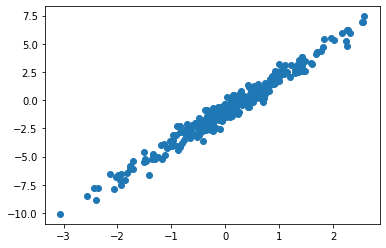

In [5]:
import numpy as np
import matplotlib.pyplot as plt

n = 300
xs = np.random.normal(size=(n,))
noise = np.random.normal(scale=0.5, size=(n,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [6]:
# theta = [w, b] - model parameters
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

Loss function is the sum of squared errors, $ L = \Sigma (y - y_{pred})^2$

In [7]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [8]:
loss_fn((3,1), 0, 4)

Array(9., dtype=float32)

In [9]:
loss_fn((3,1), xs, ys)

Array(4.0649104, dtype=float32)

Use gradient discend to find the optimal parameters, 
$$
\theta_{updated}=\theta + \lambda\nabla_{\theta}L(\theta, x, y)
$$
where $\lambda$ is learning rate.

In [10]:
@jax.jit
def update(theta, x, y, lr=0.1):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [11]:
theta = jnp.array([1., 1.])
theta

Array([1., 1.], dtype=float32)

In [12]:
grad(loss_fn)(theta, 1., 1.)

Array([2., 2.], dtype=float32)

In [13]:
grad(loss_fn)(theta, 2., -1.)

Array([16.,  8.], dtype=float32)

Gradient returns the average gradient for vectors of parameters.

In [14]:
grad(loss_fn)(theta, jnp.array([1., 2.]), jnp.array([1., -1.]))

Array([9., 5.], dtype=float32)

In [15]:
# initial parateters
theta = jnp.array([1., 1.])
theta
n_iterations = 200
lr = .1
for i in range(n_iterations):
    theta = update(theta, xs, ys, lr=lr)
theta

Array([ 2.9829342 , -0.94883674], dtype=float32)

### Compute greeks of Black-Scholes option prices with jax.grad

In [16]:
#@jax.jit
def bs_call(S, X, T, sig, r):
    d1 = (jnp.log(S/X) + (r + .5 * sig**2) * T)/(jnp.sqrt(T) * sig)
    print(f'd1 = {d1}')
    d2 = d1 - jnp.sqrt(T) * sig
    print(f'd2 = {d2}')
    c = S * jax.scipy.stats.norm.cdf(d1) - X * jnp.exp(-r*T)* jax.scipy.stats.norm.cdf(d2)
    print(f'delta = {jax.scipy.stats.norm.cdf(d1)}')
    return c

In [17]:
S=60.
X=65.
r=.08
sig=.30
T=.25
bs_call(S, X, T, sig, r)

d1 = -0.3252846896648407
d2 = -0.4752846956253052
delta = 0.3724828064441681


Array(2.1333694, dtype=float32)

In [18]:
# pars = [S, X, T, sig, r]
def euro_call(pars):
    S, X, T, sig, r = pars
    c = bs_call(S, X, T, sig, r)
    return c

In [19]:
euro_call([S, X, T, sig, r])

d1 = -0.3252846896648407
d2 = -0.4752846956253052
delta = 0.3724828064441681


Array(2.1333694, dtype=float32)

In [20]:
pars = [S, X, T, sig, r]
jax.grad(euro_call)(pars)

d1 = Traced<ConcreteArray(-0.3252846896648407, dtype=float32, weak_type=True)>with<JVPTrace(level=2/0)> with
  primal = Array(-0.3252847, dtype=float32, weak_type=True)
  tangent = Traced<ShapedArray(float32[], weak_type=True)>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[], weak_type=True), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fb24a6971f0>, in_tracers=(Traced<ConcreteArray(0.15000000596046448, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(-0.048792704939842224, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(44.44444274902344, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7fb24c3c2ca0; to 'JaxprTracer' at 0x7fb24c3c25c0>], out_avals=[ShapedArray(float32[], weak_type=True)], primitive=xla_call, params={'devi

[Array(0.3724828, dtype=float32, weak_type=True),
 Array(-0.31100923, dtype=float32, weak_type=True),
 Array(8.428175, dtype=float32, weak_type=True),
 Array(11.351544, dtype=float32, weak_type=True),
 Array(5.0539, dtype=float32, weak_type=True)]

In [21]:
np.sqrt(4) + 2

4.0

### Random numbers

In [22]:
key = jax.random.PRNGKey(42)
print(random.normal(key, shape=(5,)))
print(random.normal(key, shape=(5,)))

[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]
[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]


In [23]:
# never reuse a key
key, subkey = random.split(key)
print(random.normal(subkey, shape=(5,)))
key, subkey = random.split(key)
print(random.normal(subkey, shape=(5,)))

[-0.55338794  0.944283   -0.74176395 -0.5769758   1.1251862 ]
[-0.32761317 -0.4066346   1.2469071   1.1900425   1.100263  ]


## Common models

### Linear model

$y = wx + b$

Generate observed values

In [24]:
key = jax.random.PRNGKey(212)
w = jnp.array([1., -1., 3., 5., -2.])
b = 2
theta_true = jnp.append(w, b)
print(theta_true)

[ 1. -1.  3.  5. -2.  2.]


In [25]:
@jax.jit
def model(theta, x):
    w = theta[:-1]
    b = theta[-1]
    y = jnp.dot(w, x) + b
    return y

model_vmap = jax.vmap(model, in_axes=[None, 1])

In [26]:
model(theta_true, jnp.array([1, 2, 3, 4, 5]))

Array(20., dtype=float32)

In [27]:
np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]).reshape(5, 2)

array([[1, 2],
       [3, 4],
       [5, 1],
       [2, 3],
       [4, 5]])

In [29]:
#model_vmap(theta, np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]).reshape(5, 2))

In [30]:
n_obs = 50
x_observed = jax.random.normal(key, shape=(5,n_obs))
print(x_observed.shape)
print(jnp.sum(x_observed, axis=1))


(5, 50)
[-1.9834332  3.693717  -2.6479702  1.790731  12.152575 ]


In [31]:
# observations - model plus some noise
y_observed = model(theta_true, x_observed) + jax.random.normal(key, shape=(n_obs,))
print(y_observed)

[  5.061532     2.4697185   -3.1689067   -7.6509895   -3.878571
  11.230026     1.4037006    4.2314587    9.178272     5.9207597
  -1.3583989   -4.3980184    5.3401203    0.41575944  -1.9732022
  -8.83993      6.2698207   -2.5513077    6.314845    -8.689926
  -1.7106991   -5.669702     8.188997    10.294529     5.785759
  -5.8465557   17.606495     5.477191    11.000769     7.3086863
  -3.7401242    6.787878     8.182899     1.5911278    1.0267415
   4.3348236   -5.980621   -11.129906    -4.772352    -3.095614
  -0.26369235  -5.845175    -2.9242475    3.4858134   11.435972
  11.133466    -4.316735     0.92751443  -5.489374    -8.450031  ]


Text(0.5, 1.0, 'Noisy observations vs underlying model')

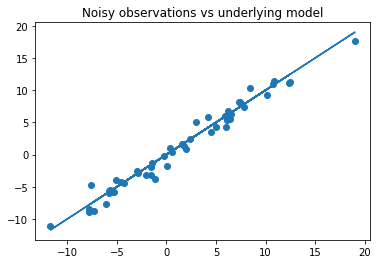

In [32]:
plt.scatter(model(theta_true, x_observed), y_observed)
plt.plot(model(theta_true, x_observed), model(theta_true, x_observed))
plt.title('Noisy observations vs underlying model')

In [34]:
%timeit model(theta_true, x_observed)

6 µs ± 111 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [35]:
y_observed = model_vmap(theta_true, x_observed)
print(y_observed)

[ 2.9883358e+00  2.3349292e+00 -1.5650349e+00 -6.1130486e+00
 -5.0836453e+00  1.2472522e+01  1.8045750e+00  5.0270219e+00
  1.0129258e+01  5.9141598e+00 -1.4724889e+00 -4.2724571e+00
  6.0810962e+00  5.5440164e-01 -1.5313129e+00 -7.7776632e+00
  6.5286217e+00 -2.9492378e+00  6.2737894e+00 -7.3210154e+00
  1.4329433e-02 -5.8055058e+00  7.4530363e+00  8.3956413e+00
  4.1605120e+00 -5.3344989e+00  1.8990660e+01  6.3681188e+00
  1.0795193e+01  7.7783060e+00 -1.1883299e+00  6.2501445e+00
  7.3560805e+00  1.6167390e+00  3.5765314e-01  6.0111747e+00
 -5.7826834e+00 -1.1694789e+01 -7.5610752e+00 -2.0660710e+00
 -2.2288561e-01 -5.6120420e+00 -2.8691711e+00  4.5343022e+00
  1.0853861e+01  1.2338906e+01 -4.6002135e+00  1.9807792e+00
 -5.6962886e+00 -7.8172445e+00]


In [36]:
# slower tham model?
%timeit model_vmap(theta_true, x_observed)

513 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [38]:
# loss function - mean squared error
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [39]:
# update step
@jax.jit
def update(theta, x, y, lr=0.01):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [40]:
# initial parateters
theta = jnp.array([1., 1., 1., 1., 1., 1.])
theta
n_iterations = 1000
lr = .01
for i in range(n_iterations):
    theta = update(theta, x_observed, y_observed, lr=lr)
print(theta)
print(theta_true)


[ 1.0000066 -0.9999936  2.9999955  5.0000114 -1.9999946  1.999995 ]
[ 1. -1.  3.  5. -2.  2.]


### Logistic regression classifier

First, we create data using bivariate normal distribution.

In [41]:
class1 = random.multivariate_normal(key,
                           mean=jnp.array([1, 1]),
                           cov=.5*np.array([1, .5, .5, 1]).reshape(2,2),
                          shape=[100,])
class1[:5,:]

Array([[ 2.2076726 ,  0.6332452 ],
       [ 0.53972983, -0.51073563],
       [ 1.6998711 ,  1.4444137 ],
       [-0.05809402,  1.330411  ],
       [ 0.23326337,  0.6060622 ]], dtype=float32)

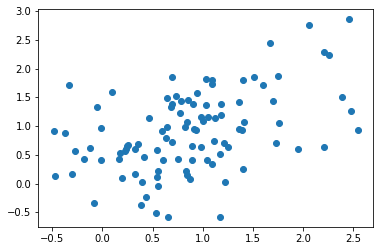

In [42]:
plt.scatter(class1[:, 0], class1[:, 1])

In [43]:
key, subkey = random.split(key)
class2 = random.multivariate_normal(key,
                           mean=jnp.array([3, 3]),
                           cov=.25*np.array([1, .7, .7, 1]).reshape(2,2),
                          shape=[100,])
class2[:5,:]

Array([[3.4657753, 3.195562 ],
       [2.5691884, 3.163034 ],
       [2.985951 , 2.7663414],
       [2.1083503, 2.027696 ],
       [2.6487987, 2.8870454]], dtype=float32)

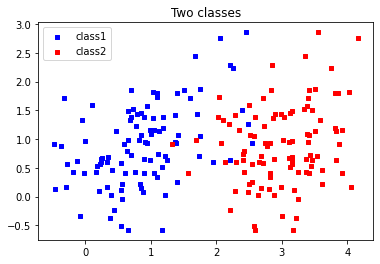

In [44]:

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(class1[:, 0], class1[:, 1], s=10, c='b', marker="s", label='class1')
ax1.scatter(class2[:, 0], class1[:, 1], s=10, c='r', marker="s", label='class2')
plt.title('Two classes')
plt.legend()


Logistic regression models the probability of belonging to $class1$ as
$$
p = \frac{1}{1+e^{-(wx + b)}},
$$
where, in our case, $w = (w_1, w_2), x = (x_1, x_2)$, and $b$ is a scalar.
The loss function at $p_k, y_k$ is defined as 

$$
\left\{
\begin{array}{l}
      -log(p_k),\ if\  y_k = 1\ \    (class 1),\\
      -log(1-p_k),\ if\  y_k=0 \ \    (class 2).
      \end{array}
  \right.
$$
Combining, we get cross entropy loss function

$$
L = -\Sigma_1^N (y_k\log(p_k) + (1-y_k)log(1-p_k)).
$$

In [65]:
# implement functions
@jax.jit
def sigmoid(t):
    return 1/(1 + jnp.exp(-t))

@jax.jit
def model(theta, x):
    w = theta[:-1]
    b = theta[-1]
    t = jnp.dot(w, x) + b
    p = sigmoid(t)
    return p

# loss function - cross entropy
def loss_fn(theta, x, y):
  p = model(theta, x)
#  print(theta.dtype)
#  print(y.dtype)
# print(y*(jnp.log(p) + (1-y)*jnp.log(1-p)))    
  return -jnp.mean(y*(jnp.log(p) + (1-y)*jnp.log(1-p)))

# update step
@jax.jit
def update(theta, x, y, lr=0.01):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [66]:
class1[:5, :]

Array([[ 2.2076726 ,  0.6332452 ],
       [ 0.53972983, -0.51073563],
       [ 1.6998711 ,  1.4444137 ],
       [-0.05809402,  1.330411  ],
       [ 0.23326337,  0.6060622 ]], dtype=float32)

In [67]:
theta = np.array([1., 1., 1.])
model(theta, class1[:5, :].transpose())

Array([0.97897756, 0.73672086, 0.98439276, 0.9065582 , 0.8628689 ],      dtype=float32)

In [68]:
loss_fn(theta, class1[:, :].transpose(), jnp.ones(shape=(len(class1),)))

Array(0.09995721, dtype=float32)

In [69]:
update(theta, class1[:, :].transpose(), jnp.ones(shape=(len(class1),)))

Array([1.0003867, 1.0003953, 1.0009131], dtype=float32)

In [70]:
#input data
lbl = jnp.concatenate((jnp.ones(shape=(len(class1),)), jnp.zeros(shape=(len(class2),))))
data = jnp.column_stack((jnp.row_stack((class1, class2)), lbl))
print(data.shape)
print(data[:5, :])
print(data[-5:, :])
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data[:,:-1], 
    data[:,-1], 
    test_size=0.3, random_state=212
)

(200, 3)
[[ 2.2076726   0.6332452   1.        ]
 [ 0.53972983 -0.51073563  1.        ]
 [ 1.6998711   1.4444137   1.        ]
 [-0.05809402  1.330411    1.        ]
 [ 0.23326337  0.6060622   1.        ]]
[[3.8604279 4.300192  0.       ]
 [3.019225  2.9260416 0.       ]
 [3.8114538 3.4090698 0.       ]
 [3.5774093 3.9309077 0.       ]
 [1.5694052 1.8653797 0.       ]]


In [71]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_test.sum())

(140, 2)
(60, 2)
(140,)
(60,)
30.0


In [82]:
# fit parameters
# initial parateters
theta = jnp.array([1., 1., 1.])
n_iterations = 1000
lr = .1
for i in range(n_iterations):
    #print(theta)
    theta = update(theta, X_train.transpose(), y_train, lr=lr)
    print(loss_fn(theta, X_train.transpose(), y_train))
print(theta)

0.053826768
0.053521108
0.05321896
0.052920252
0.05262494
0.052332953
0.05204425
0.05175876
0.051476434
0.051197223
0.050921068
0.050647937
0.050377756
0.05011049
0.04984609
0.049584508
0.049325697
0.04906961
0.04881621
0.048565462
0.048317306
0.04807172
0.04782865
0.047588058
0.04734991
0.047114175
0.046880808
0.046649776
0.046421032
0.046194557
0.045970306
0.045748264
0.045528382
0.045310624
0.045094974
0.044881392
0.044669855
0.044460338
0.04425279
0.0440472
0.04384353
0.043641765
0.043441873
0.04324383
0.04304761
0.042853177
0.042660516
0.0424696
0.04228041
0.042092912
0.041907094
0.041722935
0.041540407
0.04135948
0.04118015
0.04100238
0.040826157
0.040651463
0.040478278
0.040306576
0.040136337
0.03996755
0.039800197
0.03963425
0.0394697
0.03930652
0.039144706
0.038984224
0.03882508
0.038667236
0.038510684
0.038355414
0.038201403
0.038048636
0.037897095
0.03774678
0.03759765
0.037449714
0.037302952
0.03715734
0.03701288
0.036869545
0.03672733
0.03658622
0.0364462
0.03630726
0.0361

0.00866688
0.008659087
0.008651313
0.008643551
0.008635806
0.008628074
0.008620354
0.008612651
0.008604956
0.008597277
0.00858961
0.008581961
0.008574328
0.008566702
0.008559092
0.008551494
0.008543912
0.008536344
0.008528788
0.008521246
0.008513712
0.0085061975
0.008498694
0.008491205
0.00848373
0.008476267
0.008468815
0.008461378
0.008453957
0.008446545
0.00843914
0.008431765
0.008424389
0.008417026
0.008409683
0.008402348
0.008395033
0.008387719
0.008380428
0.008373144
0.008365876
0.008358622
0.008351378
0.008344143
0.008336925
0.008329719
0.008322524
0.008315341
0.008308172
0.008301018
0.008293871
0.008286735
0.008279617
0.00827251
0.008265415
0.0082583325
0.008251257
0.008244204
0.008237157
0.008230118
0.008223092
0.008216092
0.008209089
0.008202096
0.008195125
0.008188157
0.008181206
0.008174275
0.008167345
0.008160425
0.008153523
[1.4880625 1.4798967 2.7190077]


In [83]:
jnp.column_stack((model(theta, X_train.transpose()), y_train))

Array([[0.9999496 , 0.        ],
       [0.98426384, 1.        ],
       [0.99999917, 0.        ],
       [0.99999666, 0.        ],
       [0.9934238 , 1.        ],
       [0.9999962 , 0.        ],
       [0.99994874, 1.        ],
       [0.9999877 , 0.        ],
       [0.99997735, 0.        ],
       [0.9999877 , 0.        ],
       [0.99995565, 0.        ],
       [0.96947   , 1.        ],
       [0.9999883 , 0.        ],
       [0.9999863 , 0.        ],
       [0.99985766, 0.        ],
       [0.9990909 , 1.        ],
       [0.9999987 , 0.        ],
       [0.9862389 , 1.        ],
       [0.9985317 , 1.        ],
       [0.99999857, 0.        ],
       [0.9999708 , 0.        ],
       [0.9999995 , 0.        ],
       [0.9999963 , 0.        ],
       [0.9999956 , 0.        ],
       [0.9735058 , 1.        ],
       [0.9943652 , 1.        ],
       [0.99999917, 0.        ],
       [0.99999905, 0.        ],
       [0.99995375, 0.        ],
       [0.99996126, 0.        ],
       [0.

### LSTM by chatGPT

In [256]:
import jax.numpy as np
from jax import grad, jit, vmap

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def lstm_cell(hidden_state, cell_state, input_vector, params):
    W_f, b_f, W_i, b_i, W_o, b_o, W_c, b_c = params

    # forget gate
    forget_gate = sigmoid(np.dot(input_vector, W_f) + np.dot(hidden_state, W_f) + b_f)

    # input gate
    input_gate = sigmoid(np.dot(input_vector, W_i) + np.dot(hidden_state, W_i) + b_i)

    # candidate cell state
    candidate_cell_state = tanh(np.dot(input_vector, W_c) + np.dot(hidden_state, W_c) + b_c)

    # cell state
    cell_state = forget_gate * cell_state + input_gate * candidate_cell_state

    # output gate
    output_gate = sigmoid(np.dot(input_vector, W_o) + np.dot(hidden_state, W_o) + b_o)

    # hidden state
    hidden_state = output_gate * tanh(cell_state)

    return hidden_state, cell_state

def lstm(inputs, initial_hidden_state, initial_cell_state, params):
    def step(hidden_state_and_cell_state, input_vector):
        hidden_state, cell_state = hidden_state_and_cell_state
        new_hidden_state, new_cell_state = lstm_cell(hidden_state, cell_state, input_vector, params)
        return new_hidden_state, new_cell_state
    hidden_states, cell_states = np.scan(step, inputs, (initial_hidden_state, initial_cell_state))
    return hidden_states, cell_states

# example usage
inputs = np.array([[1, 2, 3], [4, 5, 6]])
initial_hidden_state = np.zeros((2, 10))
initial_cell_state = np.zeros((2, 10))
params = [np.zeros((3, 10)), np.zeros(10), np.zeros((3, 10)), np.zeros(10), np.zeros((3, 10)), np.zeros(10), np.zeros((3, 10)), np.zeros(10)]

hidden_states, cell_states = lstm(inputs, initial_hidden_state, initial_cell_state, params)


AttributeError: module 'jax.numpy' has no attribute 'scan'